# Librairies

In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pylab as plt
import numpy as np
import zipfile
from tqdm import tqdm

# Load data

In [2]:
# Open the gzip-compressed file
year = 2023
filenames = [
    f'january{year}',
    f'february{year}',
    f'march{year}',
    f'april{year}',
    f'may{year}',
    f'june{year}',
    f'july{year}',
    f'august{year}',
    f'september{year}',
    f'october{year}',
    f'november{year}',
    f'december{year}',
]
filenames2 = filenames = [
    f'January{year}',
    f'February{year}',
    f'March{year}',
    f'April{year}',
    f'May{year}',
    f'June{year}',
    f'July{year}',
    f'August{year}',
    f'September{year}',
    f'October{year}',
    f'November{year}',
    f'December{year}',
]

l_df = []

for filename, filename2 in tqdm(zip(filenames, filenames2)):
    # takes a few seconds
    with zipfile.ZipFile(f'raw/scats{filename}.zip', 'r') as z:
        with z.open(f'SCATS{filename2}.csv') as f :
            df = pd.read_csv(f, usecols=range(5))
            # Convert to time
            df.End_Time = pd.to_datetime(df.End_Time, format = '%Y%m%d%H%M%S')
            # Sum over sites' detectors
            df = df.groupby(['End_Time', 'Site']).agg(AADT = ('Sum_Volume', 'sum'))
            # # groupby days
            # # There is a need to manage missing data (for instance if we miss some of the hours)
            # # Get mean hour valluue for this road segment ?
            # df['day'] = df.index.get_level_values(0).date
            # df = df.groupby(['Site', 'day']).sum()
            l_df.append(df)
            # memory
            df=None
            
df = pd.concat(l_df)
l_df = None

12it [00:48,  4.01s/it]


In [4]:
# This should be done with gdf prior to join

import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from temporal_agg import hourly_to_aadt

# df, sensor_id_name, time_name, counts_name

In [5]:
df = hourly_to_aadt(df.swaplevel(), 'Site', 'End_Time', ['AADT'])

In [6]:
# Remove obvious outliers
df = df[df.AADT >= 100].dropna()
# These are outliers too - perhaps counts several roads
df = df[df.AADT <= 50000]

In [7]:
df.AADT.describe()

count      832.000000
mean     17577.714073
std      10785.719564
min        130.486068
25%       9142.115007
50%      16118.544810
75%      24254.522260
max      49933.847143
Name: AADT, dtype: float64

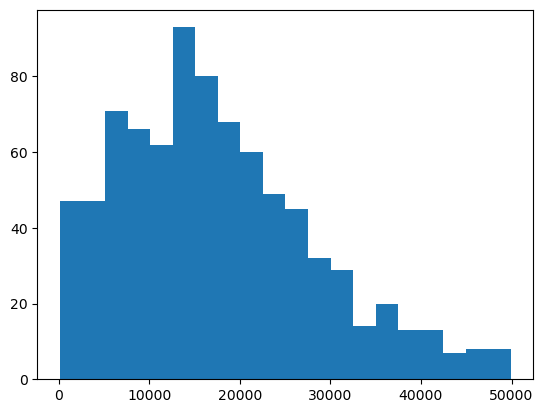

In [8]:
plt.hist(df.AADT, bins = 20,
         #range = (0, 1000)
         )
plt.show()

In [9]:
# referential
ref = gpd.read_file('raw/dcc_traffic_signal_sites_20221130.geojson')

In [10]:
ref.columns

Index(['SiteID', 'Site_Description_Cap', 'Site_Description_Lower', 'Region',
       'Lat', 'Long', 'Site_Type', 'geometry'],
      dtype='object')

In [11]:
ref

,SiteID,Site_Description_Cap,Site_Description_Lower,Region,Lat,Long,Site_Type,geometry
0,1,ABBEY ST @ MARLBOROUGH ST (LUAS),abbey st @ marlborough st (luas),CCITY,53.348754,-6.257607,SCATS Site,POINT (-6.25761 53.34875)
1,2,AMIENS ST @ SEVILLE PL,amiens st @ seville pl,CCITY,53.354711,-6.246679,SCATS Site,POINT (-6.24668 53.35471)
2,3,AMIENS ST @ TALBOT ST,amiens st @ talbot st,CCITY,53.351374,-6.250073,SCATS Site,POINT (-6.25007 53.35137)
3,4,ANNESLEY PL @ POPLAR ROW,annesley pl @ poplar row,NCITY,53.361145,-6.240513,SCATS Site,POINT (-6.24051 53.36114)
4,5,NCR @ AUGHRIM ST,ncr @ aughrim st,WCITY1,53.355797,-6.292406,SCATS Site,POINT (-6.29241 53.3558)
...,...,...,...,...,...,...,...,...
820,964,NORTH CIRCULAR ROAD @ TUD,north circular road @ tud,WCITY1,53.357519,-6.286843,SCATS Site,POINT (-6.28684 53.35752)
821,965,HOLE IN THE WALL / MARSFIELD BELMAYNE,hole in the wall / marsfield belmayne,DCC1,53.408150,-6.161950,SCATS Site,POINT (-6.16195 53.40815)
822,968,BRIDE ST @ BRIDE RD,bride st @ bride rd,SCITY,53.341474,-6.270088,SCATS Site,POINT (-6.27009 53.34147)
823,974,BLACKHORSE AVE @ NEPHIN RD,blackhorse ave @ nephin rd,WCITY1,53.362728,-6.311709,SCATS Site,POINT (-6.31171 53.36273)


In [12]:
#Site_Type : Site type; it has two values: SCATS or Signal Site
# - SCATS means that both SCATS detectors and traffic signals (traffic lights) are present.
# - Signal Site value means that only traffic signals are present.

jf = ref[ref.Site_Type == 'SCATS Site'].rename(
    columns={"SiteID":'Sites', 'Site_Description_Lower':'Street_name'}
    ).set_index('Sites').join(df)

# Map matching with OSM

In [13]:
from map_matching_OSM import points_matching

In [14]:
jf = points_matching(jf)

City downloaded


 48%|████▊     | 323/667 [00:02<00:02, 127.41it/s]

Value Error - No roads found nearby current index


 63%|██████▎   | 421/667 [00:03<00:03, 81.04it/s] 

Value Error - No roads found nearby current index


 72%|███████▏  | 483/667 [00:04<00:02, 78.72it/s]

Value Error - No roads found nearby current index


 92%|█████████▏| 612/667 [00:05<00:00, 107.35it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


100%|██████████| 667/667 [00:05<00:00, 113.45it/s]

We failed to match 5 sensors
...on a total of 667 sensors


In [15]:
jf[['Street_name', 'osm_name']].dropna().drop_duplicates()[:20]

,Street_name,osm_name
Sites,,
1,abbey st @ marlborough st (luas),Abbey Street Lower
2,amiens st @ seville pl,North Strand Road
3,amiens st @ talbot st,Amiens Street
4,annesley pl @ poplar row,Poplar Row
5,ncr @ aughrim st,North Circular Road
6,baggot st bridge,Baggot Street Lower
7,baggot st @ fitzwilliam st,Fitzwilliam Street Lower
8,baggot st @ waterloo rd,Baggot Street Upper
9,ballybough rd @ clonliffe rd (luke kelly br),Clonliffe Road


# Final saving

In [16]:
jf.rename(columns = {'AADT_AAWT':'AAWT', 'Street_name':'raw_name'}, inplace=True)

In [17]:
jf[['AADT', 'AAWT', 'raw_name', 'geometry', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osm_distance', 'osmid']].to_file(f'treated/Dublin_AADT_AAWT_{year}.geojson', index = False)